# Time Series Models

## Evaluating India's Covid cases

### Installing and Importing Relevant packages

In [1]:
!pip install --upgrade statsmodels

     |████████████████████████████████| 9.8 MB 4.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 6.2 MB/s 


In [3]:
!pip install arch

     |████████████████████████████████| 902 kB 5.0 MB/s 


In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

In [92]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
#from statsmodels.formula.api import 

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from fbprophet import Prophet

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Project/Data/cleaned_covid.csv')
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,reproduction_rate,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,life_expectancy,human_development_index,new_deaths_sma
0,AUS,Oceania,Australia,2020-03-12,128.0,0.0,10.429,3.0,0.0,2.17,...,10.129,44648.71,0.5,107.791,5.07,13.0,16.5,83.44,0.944,0.0
1,AUS,Oceania,Australia,2020-03-13,200.0,72.0,20.000,3.0,0.0,2.34,...,10.129,44648.71,0.5,107.791,5.07,13.0,16.5,83.44,0.944,0.0
2,AUS,Oceania,Australia,2020-03-14,250.0,50.0,26.714,3.0,0.0,2.32,...,10.129,44648.71,0.5,107.791,5.07,13.0,16.5,83.44,0.944,0.0
3,AUS,Oceania,Australia,2020-03-15,297.0,47.0,31.571,3.0,0.0,2.33,...,10.129,44648.71,0.5,107.791,5.07,13.0,16.5,83.44,0.944,0.0
4,AUS,Oceania,Australia,2020-03-16,377.0,80.0,40.857,3.0,0.0,2.39,...,10.129,44648.71,0.5,107.791,5.07,13.0,16.5,83.44,0.944,0.0


In [7]:
df['date'] = pd.to_datetime(df['date'])
df['date'].dtype

dtype('<M8[ns]')

### Selecting India's data

In [8]:
ind = df[['date', 'new_cases']].loc[df['location'] == 'India']
ind.head()

,date,new_cases
3515,2020-03-12,11.0
3516,2020-03-13,9.0
3517,2020-03-14,20.0
3518,2020-03-15,11.0
3519,2020-03-16,6.0


#### Setting date column as Index

In [9]:
ind.set_index('date', inplace=True)
ind.head()

,new_cases
date,
2020-03-12,11.0
2020-03-13,9.0
2020-03-14,20.0
2020-03-15,11.0
2020-03-16,6.0


In [10]:
ind.describe()

,new_cases
count,703.000000
mean,60642.046942
std,84333.050716
min,0.000000
25%,12779.500000
50%,32981.000000
75%,62241.000000
max,414188.000000


#### Replacing random rows with zero

In [11]:
ind.loc[ind['new_cases'] == 0]

,new_cases
date,
2021-01-08,0.0
2021-12-04,0.0
2021-12-17,0.0


In [12]:
ind.replace(to_replace=0, method='ffill', inplace=True)

new_cases    None
dtype: object

#### India's new cases over time

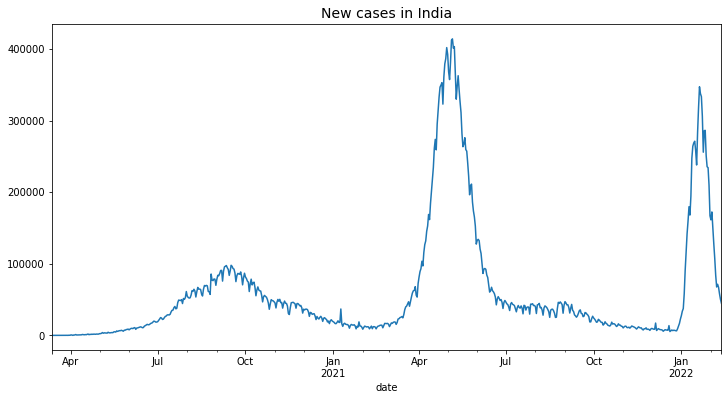

In [13]:
rcParams["figure.figsize"] = 12, 6
ind['new_cases'].plot()
plt.title('New cases in India', fontsize=14)
plt.show()

In [14]:
ind['log_trans'] = np.log(ind['new_cases'])

#### ACF and PACF plots after log tranformation

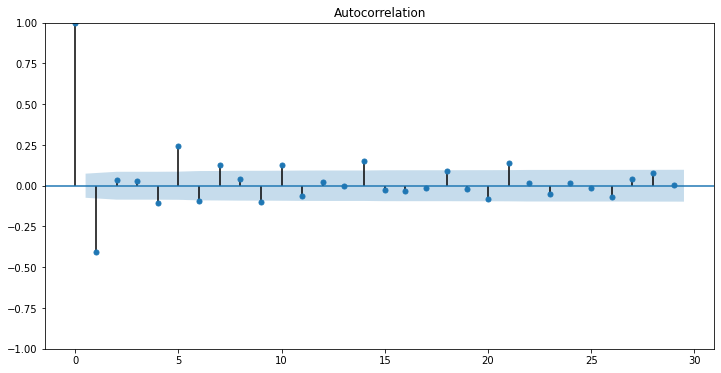

In [15]:
plot_acf(ind['log_trans'].diff().dropna())
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


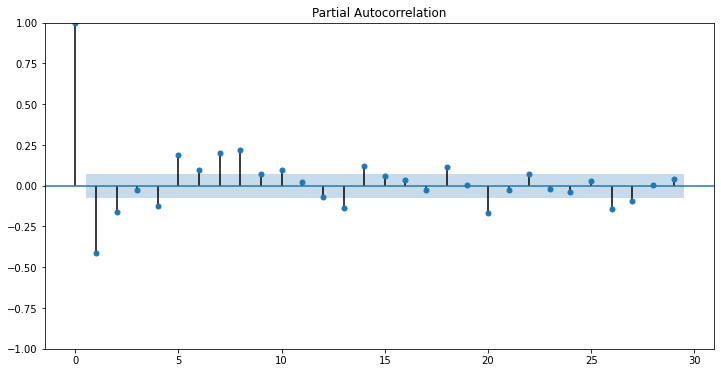

In [16]:
plot_pacf(ind['log_trans'].diff().dropna())
plt.show()

#### Setting Frequency as Daily

In [17]:
ind.index

DatetimeIndex(['2020-03-12', '2020-03-13', '2020-03-14', '2020-03-15',
               '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19',
               '2020-03-20', '2020-03-21',
               ...
               '2022-02-03', '2022-02-04', '2022-02-05', '2022-02-06',
               '2022-02-07', '2022-02-08', '2022-02-09', '2022-02-10',
               '2022-02-11', '2022-02-12'],
              dtype='datetime64[ns]', name='date', length=703, freq=None)

In [18]:
ind.index.freq = 'D'

In [19]:
len(ind['new_cases'])

703

#### Train-Test Split

In [20]:
train_df = ind.iloc[:562]
test_df = ind.iloc[561:]

In [21]:
train_df.tail()

,new_cases,log_trans
date,,
2021-09-20,26115.0,10.170265
2021-09-21,26964.0,10.202258
2021-09-22,31923.0,10.371082
2021-09-23,31382.0,10.353990
2021-09-24,29616.0,10.296070


In [22]:
test_df.head()

,new_cases,log_trans
date,,
2021-09-24,29616.0,10.296070
2021-09-25,28326.0,10.251535
2021-09-26,26041.0,10.167427
2021-09-27,18795.0,9.841346
2021-09-28,18870.0,9.845329


In [23]:
test_df.tail()

,new_cases,log_trans
date,,
2022-02-08,71365.0,11.175563
2022-02-09,67084.0,11.113701
2022-02-10,58077.0,10.969525
2022-02-11,50407.0,10.827885
2022-02-12,44877.0,10.711681


In [24]:
len(test_df)

142

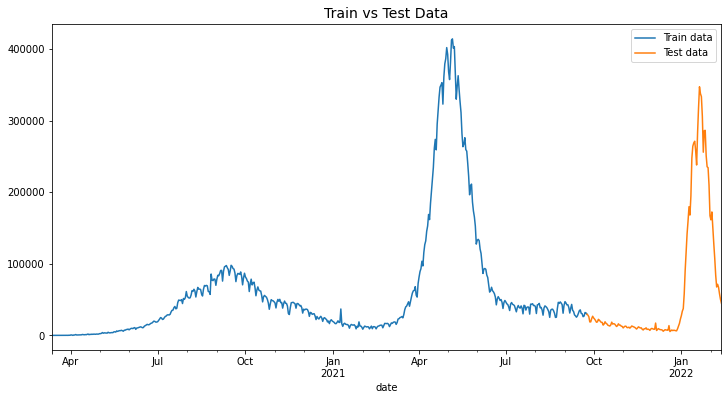

In [25]:
train_df['new_cases'].plot(label = 'Train data')
test_df['new_cases'].plot(label = 'Test data')
plt.title('Train vs Test Data', fontsize = 14)
plt.legend()
plt.show()

### Time series Modelling

#### ARIMA Model

An autoregressive integrated moving average, or ARIMA, is a statistical analysis model that uses time series data to either better understand the data set or to predict future trends. 
An ARIMA model can be understood by outlining each of its components as follows:
- Autoregression (AR): refers to a model that shows a changing variable that regresses on its own lagged, or prior, values.
- Integrated (I): represents the differencing of raw observations to allow for the time series to become stationary (i.e., data values are replaced by the difference between the data values and the previous values).
- Moving average (MA):  incorporates the dependency between an observation and a residual error from a moving average model applied to lagged observations.

The Components of ARIMA model as parameters are:
- p: the number of lag observations in the model; also known as the lag order.
- d: the number of times that the raw observations are differenced; also known as the degree of differencing.
- q: the size of the moving average window; also known as the order of the moving average.

##### Auto-ARIMA as grid search to find parameters

- Since our model was differened once, our d value is one
- We can use auto_arima from pmd arima to find best p and q values similar to performing a grid search
- The auto_arima fits models using p & q values in a range provided and evaluates based on AIC metric

In [26]:
stepwise_fit = auto_arima(ind['log_trans'], start_p=0, start_q=0,d = 1, max_p=6, max_q=8, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=173.128, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=46.337, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=31.325, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=172.449, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=29.584, Time=0.53 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=30.840, Time=0.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-41.172, Time=2.00 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=28.887, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-41.214, Time=1.99 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-21.897, Time=1.92 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-39.392, Time=3.56 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=27.280, Time=2.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=32.830, Time=1.54 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-38.946, Time=4.37 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-43.734, Tim

##### Model Forecast

In [27]:
arima_model = ARIMA(train_df['log_trans'], order=(2, 1, 3)).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [28]:
arima_predict = arima_model.predict(start = str(test_df.index[0]), end = str(test_df.index[-1]), dynamic=True)

In [29]:
np.exp(arima_predict)

2021-09-24    27786.117539
2021-09-25    27439.774829
2021-09-26    27209.293020
2021-09-27    26872.878459
2021-09-28    26649.841729
                  ...     
2022-02-08     9657.361930
2022-02-09     9624.542127
2022-02-10     9553.713418
2022-02-11     9521.739840
2022-02-12     9452.162325
Freq: D, Name: predicted_mean, Length: 142, dtype: float64

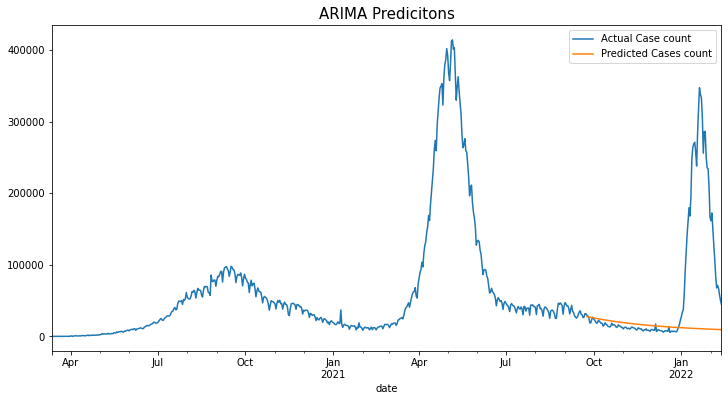

In [30]:
ind['new_cases'].plot(label = 'Actual Case count')
np.exp(arima_predict).plot(label = 'Predicted Cases count')
plt.title('ARIMA Predicitons', fontsize = 15)
plt.legend()
plt.show()

##### Observations:
The model failed to capture the third wave and overall seasonality

In [96]:
aic_scores = {}

##### Training on full data

In [31]:
arima_full = ARIMA(train_df['log_trans'], order=(2, 1, 3)).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [97]:
aic_scores['ARIMA'] = arima_full.aic

In [32]:
arima_full_predict = arima_model.predict(start = '2022-02-13', end = '2022-03-10')

In [33]:
np.exp(arima_full_predict)

2022-02-13    11737.034382
2022-02-14    11663.405304
2022-02-15    11637.551880
2022-02-16    11565.027506
2022-02-17    11539.861193
2022-02-18    11468.417668
2022-02-19    11443.922198
2022-02-20    11373.536293
2022-02-21    11349.695851
2022-02-22    11280.344944
2022-02-23    11257.144154
2022-02-24    11188.806210
2022-02-25    11166.230120
2022-02-26    11098.883673
2022-02-27    11076.917741
2022-02-28    11010.541880
2022-03-01    10989.171964
2022-03-02    10923.746312
2022-03-03    10902.958655
2022-03-04    10838.463355
2022-03-05    10818.244574
2022-03-06    10754.660276
2022-03-07    10734.997349
2022-03-08    10672.305189
2022-03-09    10653.185447
2022-03-10    10591.367039
Freq: D, Name: predicted_mean, dtype: float64

##### Observations:
- Even after training on full data, the model fails to forecast the sudden downward movement in cases.

#### Cross Validation

In [34]:
tss = TimeSeriesSplit()

In [35]:
rmse = []
for train, test in tss.split(ind['log_trans']):
    df_train = ind.iloc[train]
    df_test = ind.iloc[test]
    arima = ARIMA(df_train['log_trans'], order=(2, 1, 2))
    arima_fitted = arima.fit()
    #start = len(df_train)
    #end = len(df_train) + len(df_test)
    arima_predict = arima_fitted.predict(start = str(df_test.index[0]), end = str(df_test.index[-1]), dynamic=True)
    #print(len(df_test))
    #print(len(arima_predict))
    rmse.append(mean_squared_error(df_test['new_cases'], np.exp(arima_predict), squared = False))

In [36]:
print(rmse)

[45273.595025058545, 25191.950436457442, 194256.54388234357, 19712.19935643529, 116998.15963854388]


- WE used cross validation to train the data step by step, each time introducing previously unseen data to see whether there is any improvement.
- As we can see from the RMSE values, the model did not improve.

#### SARIMA Model

A seasonal autoregressive integrated moving average (SARIMA) model is one step different from an ARIMA model based on the concept of seasonal trends. In many time series data, frequent seasonal effects come into play.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

The parameters are:
1. The trend components same as ARIMA model:
- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.
2. There are four seasonal elements that are not part of ARIMA that must be configured; they are:
- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period.

Together, the notation for an SARIMA model is specified as: 
SARIMA(p,d,q)(P,D,Q)m

##### Seasonal Decomposition

In [37]:
seasonal_results = seasonal_decompose(ind['new_cases'])

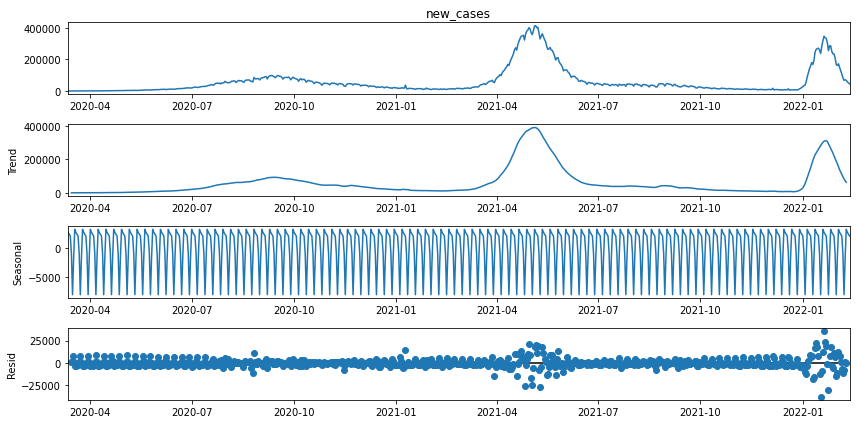

In [38]:
seasonal_results.plot();

##### Identifying Seasonality

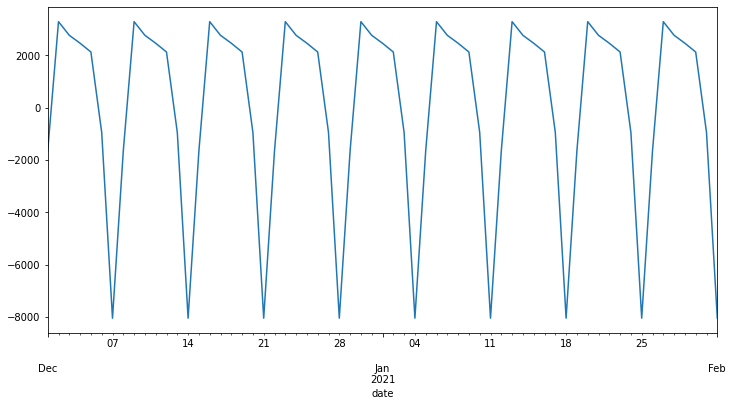

In [39]:
seasonal_results.seasonal['2020-12-01':'2021-02-01'].plot()

We observe a weekly trend. So we can take m as 7

##### Using Auto-ARIMA as Grid Search

In [40]:
auto_arima(ind['log_trans'], seasonality = True, m = 7, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[7]             : AIC=inf, Time=6.80 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=898.066, Time=0.05 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=500.051, Time=0.14 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=inf, Time=0.89 sec
 ARIMA(1,2,0)(0,0,0)[7]             : AIC=502.131, Time=0.06 sec
 ARIMA(1,2,0)(2,0,0)[7]             : AIC=485.632, Time=0.45 sec
 ARIMA(1,2,0)(2,0,1)[7]             : AIC=inf, Time=1.74 sec
 ARIMA(1,2,0)(1,0,1)[7]             : AIC=inf, Time=0.98 sec
 ARIMA(0,2,0)(2,0,0)[7]             : AIC=883.645, Time=0.27 sec
 ARIMA(2,2,0)(2,0,0)[7]             : AIC=283.832, Time=0.51 sec
 ARIMA(2,2,0)(1,0,0)[7]             : AIC=319.927, Time=0.25 sec
 ARIMA(2,2,0)(2,0,1)[7]             : AIC=213.051, Time=2.41 sec
 ARIMA(2,2,0)(1,0,1)[7]             : AIC=inf, Time=1.28 sec
 ARIMA(2,2,0)(2,0,2)[7]             : AIC=214.473, Time=4.04 sec
 ARIMA(2,2,0)(1,0,2)[7]             : AIC=214.014, Time=2.07 sec
 A

ARIMA(order=(5, 2, 2), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True, with_intercept=False)

##### Model Forecast

In [41]:
sarima_model = SARIMAX(train_df['log_trans'], order = (5, 2, 2), seasonal_order = (1, 0, 1, 7), enforce_invertibility=False).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [42]:
sarima_residuals = sarima_model.resid

In [43]:
sarima_predict = sarima_model.predict(start = str(test_df.index[0]), end = str(test_df.index[-1]), dynamic=True)

In [44]:
np.exp(sarima_predict)

2021-09-24    30510.312028
2021-09-25    29977.060440
2021-09-26    26373.738167
2021-09-27    23228.238179
2021-09-28    27759.181045
                  ...     
2022-02-08     4708.152867
2022-02-09     4958.562389
2022-02-10     4810.244603
2022-02-11     4673.271713
2022-02-12     4519.027854
Freq: D, Name: predicted_mean, Length: 142, dtype: float64

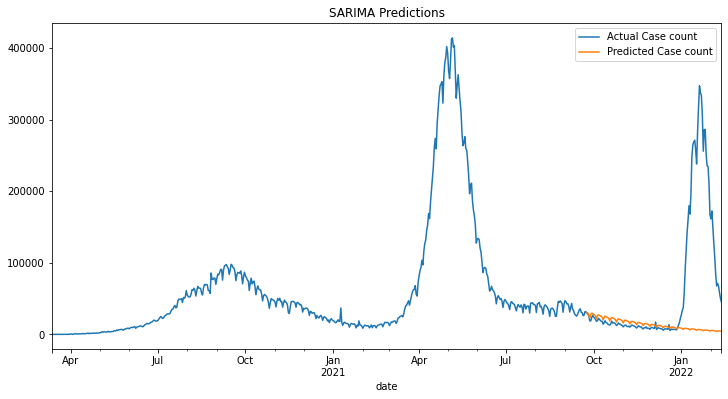

In [45]:
ind['new_cases'].plot(label = 'Actual Case count')
np.exp(sarima_predict).plot(label = 'Predicted Case count')
plt.title('SARIMA Predictions')
plt.legend()
plt.show()

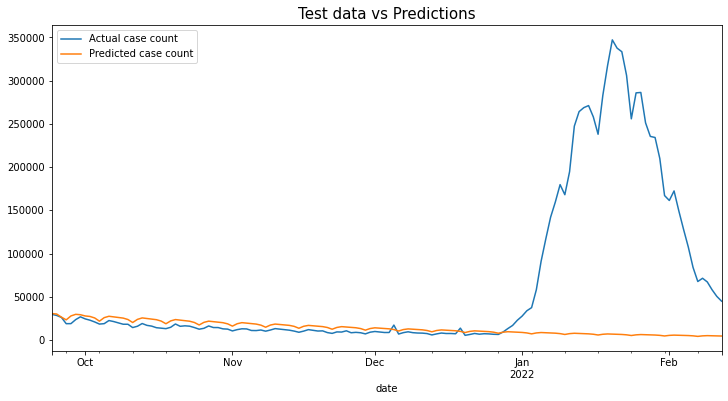

In [46]:
test_df['new_cases'].plot(label = 'Actual case count')
np.exp(sarima_predict).plot(label = 'Predicted case count')
plt.title('Test data vs Predictions', fontsize=15)
plt.legend()
plt.show()

##### Observations:
- We see that SARIMA model has captured the seasonality, but not the sudden rise in cases.

##### Training on Full data

In [47]:
sarima_full = SARIMAX(ind['log_trans'], order = (5, 2, 2), seasonal_order = (1, 0, 1, 7), enforce_invertibility=False).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [99]:
aic_scores['SARIMA'] = sarima_full.aic

In [48]:
sarima_full_predict = arima_model.predict(start = '2022-02-13', end = '2022-03-10')

In [49]:
np.exp(sarima_full_predict)

2022-02-13    11737.034382
2022-02-14    11663.405304
2022-02-15    11637.551880
2022-02-16    11565.027506
2022-02-17    11539.861193
2022-02-18    11468.417668
2022-02-19    11443.922198
2022-02-20    11373.536293
2022-02-21    11349.695851
2022-02-22    11280.344944
2022-02-23    11257.144154
2022-02-24    11188.806210
2022-02-25    11166.230120
2022-02-26    11098.883673
2022-02-27    11076.917741
2022-02-28    11010.541880
2022-03-01    10989.171964
2022-03-02    10923.746312
2022-03-03    10902.958655
2022-03-04    10838.463355
2022-03-05    10818.244574
2022-03-06    10754.660276
2022-03-07    10734.997349
2022-03-08    10672.305189
2022-03-09    10653.185447
2022-03-10    10591.367039
Freq: D, Name: predicted_mean, dtype: float64

Training on full data also failed to give desired results.

#### GARCH Model

Generalized Autoregressive Conditional Heteroskedasticity, or GARCH, is an extension of the ARCH model that incorporates a moving average component together with the autoregressive component.GARCH models are used when the variance of the error term is not constant. That is, the error term is heteroskedastic. Heteroskedasticity describes the irregular pattern of variation of an error term, or variable, in a statistical model.

Essentially, wherever there is heteroskedasticity, observations do not conform to a linear pattern. Instead, they tend to cluster. Therefore, if statistical models that assume constant variance are used on this data, then the conclusions and predictive value one can draw from the model will not be reliable.

The model has two parameters:
- p: The number of lag variances to include in the GARCH model.
- q: The number of lag residual errors to include in the GARCH model.

##### PACF Plot to identify p and q

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


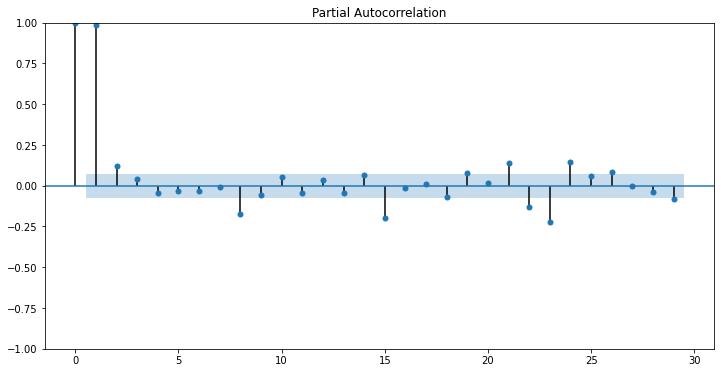

In [50]:
plot_pacf((ind['log_trans'])**2);

##### Forecasting Volatility

In [51]:
garch = arch_model(train_df['log_trans'], p = 1, q = 1)

In [52]:
garch_fit = garch.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 757.4764161666801
Iteration:      2,   Func. Count:     16,   Neg. LLF: 699.4479923208485
Iteration:      3,   Func. Count:     23,   Neg. LLF: 663.598819985508
Iteration:      4,   Func. Count:     30,   Neg. LLF: 623.6511082257925
Iteration:      5,   Func. Count:     37,   Neg. LLF: 606.8572729872825
Iteration:      6,   Func. Count:     44,   Neg. LLF: 598.6837229825293
Iteration:      7,   Func. Count:     51,   Neg. LLF: 580.6341769213242
Iteration:      8,   Func. Count:     58,   Neg. LLF: 576.2099258712392
Iteration:      9,   Func. Count:     65,   Neg. LLF: 572.1661271494513
Iteration:     10,   Func. Count:     72,   Neg. LLF: 568.7412680272805
Iteration:     11,   Func. Count:     79,   Neg. LLF: 565.8474087614137
Iteration:     12,   Func. Count:     86,   Neg. LLF: 563.4650030404075
Iteration:     13,   Func. Count:     93,   Neg. LLF: 561.5555961064099
Iteration:     14,   Func. Count:     99,   Neg. LLF: 559.2490012

In [53]:
garch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              log_trans   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -555.564
Distribution:                  Normal   AIC:                           1119.13
Method:            Maximum Likelihood   BIC:                           1136.45
                                        No. Observations:                  562
Date:                Sat, Mar 19 2022   Df Residuals:                      561
Time:                        14:33:44   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            10.6340  4.698e-02    226.354      0.000 [ 10.542, 10.726]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0114  2.567e-03      4.429  9.474e-06 [6.338e-03,1.640e-02]
alpha[1]       0.8242      0.100      8.234  1.805e-16     [  0.628,  1.020]
beta[1]        0.1401  9.048e-02      1.548      0.122  [-3.724e-02,  0.317]
============================================================================

Covariance estimator: robust
"""

In [54]:
garch_predictions = garch_fit.forecast(horizon = len(test_df))

/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


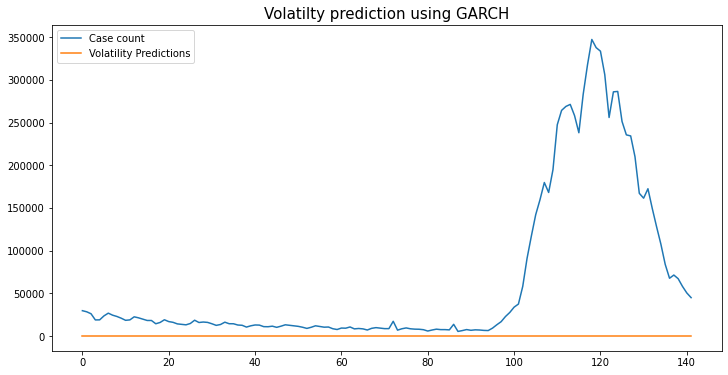

In [55]:
plt.figure(figsize=(12, 6))
plt.plot(np.exp(test_df['log_trans'].values))
plt.plot(np.sqrt(np.exp(garch_predictions.variance.values[-1, :])))
plt.legend(['Case count', 'Volatility Predictions'])
plt.title('Volatilty prediction using GARCH', fontsize=15)
plt.show()

#### SARIMA + GARCH

##### Plotting SARIMA Residuals

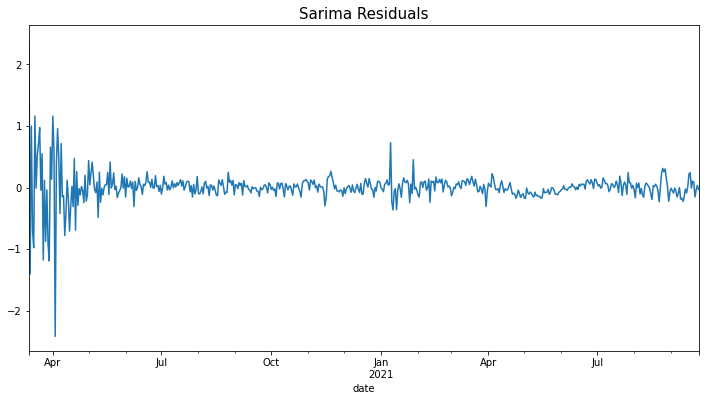

In [56]:
sarima_residuals.plot()
plt.title('Sarima Residuals', fontsize=15)
plt.show()

We are already aware of the necessary conditions of the residulas of the ARIMA model: error term εt has zero mean, homoscedasticity and the serially uncorrelated property. When time series data exhibits the conditional heteroskedastic feature, ARCH models proposed by Engle (1982) are more appropriate and should be adopted.

GARCH model is actually ARMA model for the variance, meaning we enable variance to be a function of time and we accept volatility clustering. While ARMA can model the mean of a process, GARCH enables us to model volatility of the the process. Applying both together as ARMA-GARCH model we can model both mean and volatility at the same time, relaxing the condtion of homoskedasticity.

##### PACF of SARIMA Residuals

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


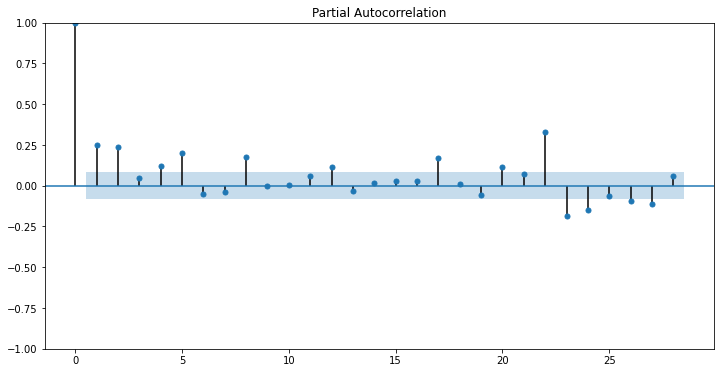

In [57]:
plot_pacf((sarima_residuals)**2);

##### Fitting GARCH on SARIMA residuals

In [58]:
garch = arch_model(sarima_residuals, p = 1, q = 1)

In [59]:
garch_fitted = garch.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: -345.81740472218274
Iteration:      2,   Func. Count:     17,   Neg. LLF: -345.8987769171448
Iteration:      3,   Func. Count:     25,   Neg. LLF: -351.39518375925934
Iteration:      4,   Func. Count:     32,   Neg. LLF: -352.4396751092889
Iteration:      5,   Func. Count:     39,   Neg. LLF: -353.66065834584765
Iteration:      6,   Func. Count:     46,   Neg. LLF: -355.70004420205385
Iteration:      7,   Func. Count:     53,   Neg. LLF: -356.54538095460623
Iteration:      8,   Func. Count:     60,   Neg. LLF: -357.2034087280266
Iteration:      9,   Func. Count:     67,   Neg. LLF: -357.8186655814073
Iteration:     10,   Func. Count:     74,   Neg. LLF: -358.2794719038451
Iteration:     11,   Func. Count:     81,   Neg. LLF: -358.56247578373603
Iteration:     12,   Func. Count:     88,   Neg. LLF: -358.86253336374364
Iteration:     13,   Func. Count:     95,   Neg. LLF: -359.1338550449905
Iteration:     14,   Func. Count:    102,   

/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06634. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


In [60]:
garch_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                359.148
Distribution:                  Normal   AIC:                          -710.297
Method:            Maximum Likelihood   BIC:                          -692.971
                                        No. Observations:                  562
Date:                Sat, Mar 19 2022   Df Residuals:                      561
Time:                        14:33:45   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         9.5244e-03  4.990e-03      1.909  5.631e-02 [-2.563e-04,1.931e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.7246e-04  2.061e-04      3.262  1.106e-03 [2.684e-04,1.076e-03]
alpha[1]       0.0494  2.466e-02      2.005  4.493e-02 [1.118e-03,9.777e-02]
beta[1]        0.8921  2.360e-02     37.795      0.000     [  0.846,  0.938]
============================================================================

Covariance estimator: robust
"""

In [61]:
garch_predict = garch_fitted.forecast(horizon = len(test_df))

/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


In [62]:
np.exp(garch_predict.residual_variance.values[-1, :])

array([1.01290801, 1.01282928, 1.01275516, 1.01268538, 1.01261969,
       1.01255784, 1.01249962, 1.0124448 , 1.01239319, 1.01234461,
       1.01229886, 1.0122558 , 1.01221525, 1.01217708, 1.01214114,
       1.01210731, 1.01207546, 1.01204547, 1.01201723, 1.01199065,
       1.01196562, 1.01194206, 1.01191987, 1.01189899, 1.01187932,
       1.01186081, 1.01184338, 1.01182697, 1.01181152, 1.01179697,
       1.01178328, 1.01177038, 1.01175824, 1.01174681, 1.01173605,
       1.01172592, 1.01171638, 1.0117074 , 1.01169895, 1.01169099,
       1.01168349, 1.01167644, 1.01166979, 1.01166354, 1.01165765,
       1.0116521 , 1.01164688, 1.01164197, 1.01163734, 1.01163298,
       1.01162888, 1.01162502, 1.01162138, 1.01161796, 1.01161474,
       1.0116117 , 1.01160885, 1.01160616, 1.01160362, 1.01160124,
       1.011599  , 1.01159688, 1.01159489, 1.01159302, 1.01159125,
       1.01158959, 1.01158803, 1.01158656, 1.01158517, 1.01158387,
       1.01158264, 1.01158148, 1.01158039, 1.01157937, 1.01157

- Fitting the residuals of SARIMA to GARCH should account for the variance in data.
- In python it is difficult to combine both models as the statsmodel contains SARIMA and arch contains GARCH; This creates a challenge when trying to make a forecast using both models at once. Due to lack of reference material combining the models in python, combining or writing a function from scratch is difficult.
- In R programming language, there is `rugarch` package.
- We can continue this work after statsmodel implements GARCH.

#### Prophet

The Prophet library is an open-source library designed for making forecasts for univariate time series datasets. It is easy to use and designed to automatically find a good set of hyperparameters for the model in an effort to make skillful forecasts for data with trends and seasonal structure by default.

The model requires us to code the date and target column as shown below.

In [63]:
india = df[['date', 'new_cases']].loc[df['location'] == 'India']
india.replace(to_replace=0, method='ffill', inplace=True)
india.columns = ['ds', 'y']
india.reset_index(drop = True, inplace = True)
india.head()

,ds,y
0,2020-03-12,11.0
1,2020-03-13,9.0
2,2020-03-14,20.0
3,2020-03-15,11.0
4,2020-03-16,6.0


In [64]:
india['ds']

0     2020-03-12
1     2020-03-13
2     2020-03-14
3     2020-03-15
4     2020-03-16
         ...    
698   2022-02-08
699   2022-02-09
700   2022-02-10
701   2022-02-11
702   2022-02-12
Name: ds, Length: 703, dtype: datetime64[ns]

In [65]:
train = india.iloc[:663]
test = india.iloc[663:]

In [66]:
len(test)

40

In [67]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods = 40)
forecast = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [68]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
698,2022-02-08,-43802.067660,-126943.870273,29746.499553,-46109.018143,-41718.459594,-1444.543970,-1444.543970,-1444.543970,-1444.543970,-1444.543970,-1444.543970,0.0,0.0,0.0,-45246.611629
699,2022-02-09,-44439.053704,-121055.364406,38640.789677,-46837.647031,-42244.790146,2558.067270,2558.067270,2558.067270,2558.067270,2558.067270,2558.067270,0.0,0.0,0.0,-41880.986434
700,2022-02-10,-45076.039747,-125551.903800,32941.086964,-47568.257316,-42765.649663,1987.138556,1987.138556,1987.138556,1987.138556,1987.138556,1987.138556,0.0,0.0,0.0,-43088.901191
701,2022-02-11,-45713.025791,-122750.424269,30123.945638,-48314.971140,-43289.282732,1984.819703,1984.819703,1984.819703,1984.819703,1984.819703,1984.819703,0.0,0.0,0.0,-43728.206088
702,2022-02-12,-46350.011835,-122436.673954,33951.115449,-49090.700262,-43842.518965,1835.786298,1835.786298,1835.786298,1835.786298,1835.786298,1835.786298,0.0,0.0,0.0,-44514.225536


Here:
- yhat column is the predictions
- yhat_upper and yhat_lower are the confidence intervals

In [69]:
test.head()

,ds,y
663,2022-01-04,58097.0
664,2022-01-05,90928.0
665,2022-01-06,117100.0
666,2022-01-07,141986.0
667,2022-01-08,159632.0


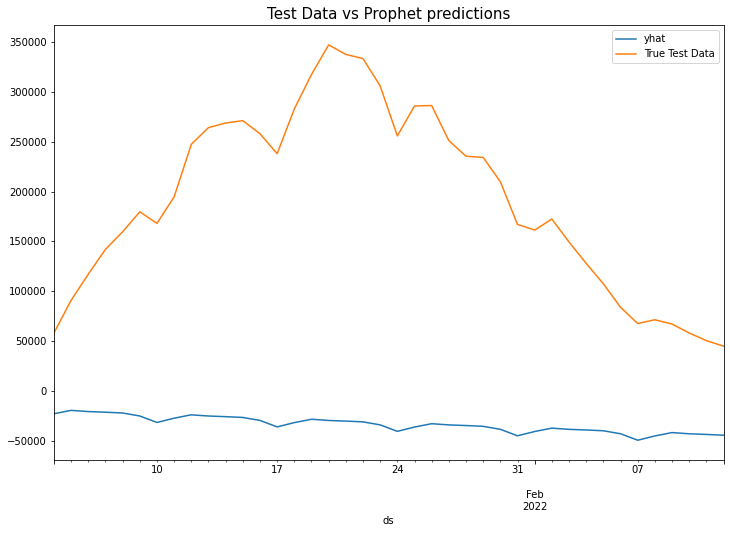

In [70]:
ax = forecast.plot(x='ds', y='yhat', legend=True, figsize=(12, 8))
test.plot(x = 'ds', y = 'y', label = 'True Test Data', ax=ax, xlim=('2022-01-04', '2022-02-12'))
plt.title('Test Data vs Prophet predictions', fontsize=15)
plt.show()

Prophet library contains its own plotting tools.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


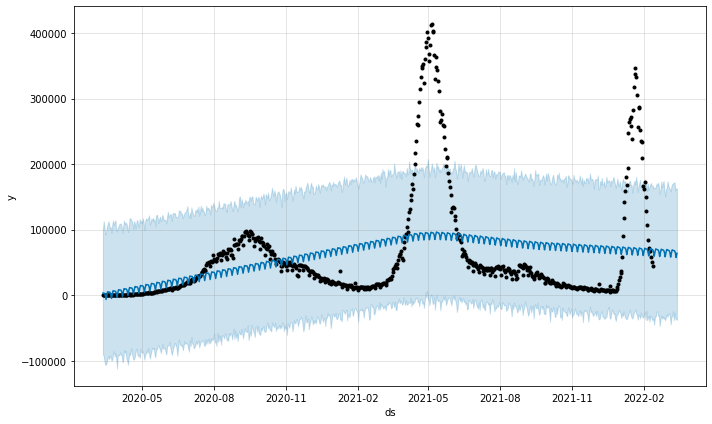

In [71]:
m = Prophet()
m.fit(india)
future = m.make_future_dataframe(periods = 31)
forecast = m.predict(future)
fig = m.plot(forecast)

##### Seasonality Components

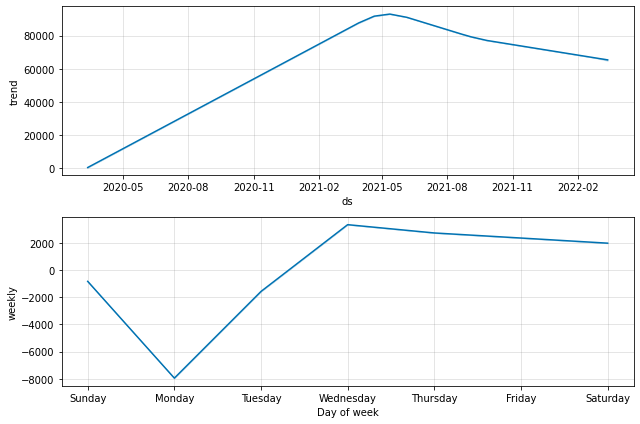

In [72]:
fig = m.plot_components(forecast)

##### Trend Plot

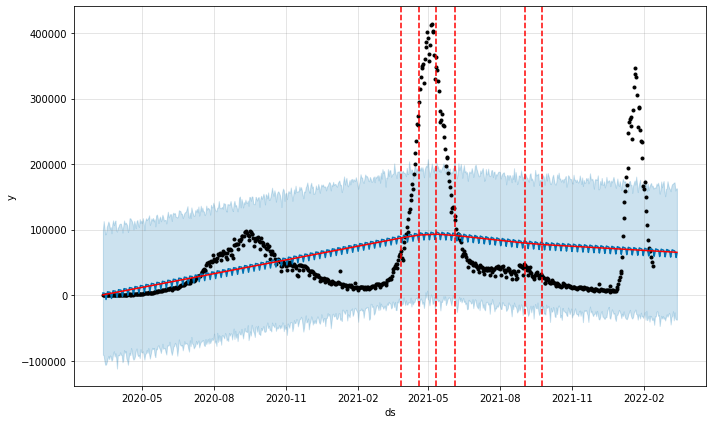

In [73]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


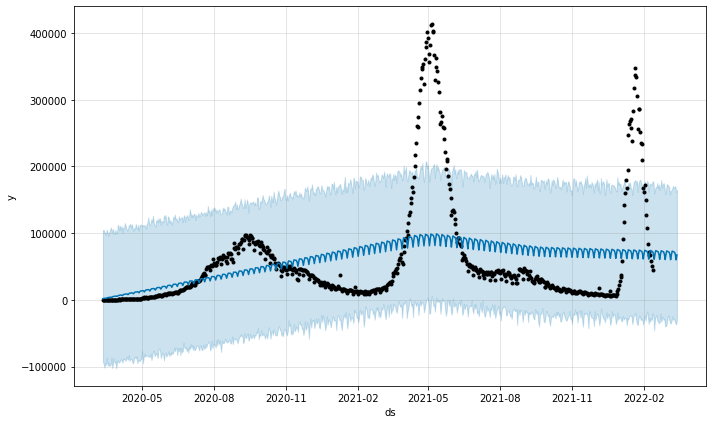

In [74]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(india)
future = m.make_future_dataframe(periods = 31)
forecast = m.predict(future)
fig = m.plot(forecast)

Prophet model also failed to give us accurate predicitons

#### Holt Winters Triple Exponential Smoothing

Holt-Winters is one of the most popular forecasting techniques for time series. Holt-Winters is a way to model three aspects of the time series: a typical value (average), a slope (trend) over time, and a cyclical repeating pattern (seasonality).

It allows us to add double and triple exponential smoothing to take into account trend and seasonality.
The Holt-Winters forecast method includes the forecast equation and three smoothing equations:
- l_t for level, smoothing parameter $\alpha$
- b_t for trend, smoothing parameter $\beta$
- s_t for seasonal components, smoothing parameter $\gamma$

There are two variation to this method based on seasonal component like seasonal decomposition; additive and multiplicative

1. Single exponential smoothing: 
- $y_{0} = x_{0}$ initial output is equal to first value
- $y_{t} = (1-\alpha)y_{t-1} + \alpha x_{t}$

2. Double exponential smoothing(Holt's Method):
- $l_{t} = (1-\alpha)l_{t-1} + \alpha x_{t}$ .......... level
- $b_{t} = (1-\beta)b_{t-1} + \beta(l_{t} - l_{t-1})$ ........... trend
- $y_{t} = l_{t} + b_{t}$ .......... fitted model
- $\hat{y_{t+h}} = l_{t} + hb_{t}$ ........... forecast where h is some period in the future

Till now we have only accounted for slope or trend. Accounting for seasonality requires triple exponential smoothing

3. Triple Exponential Smoothing(Holt-Winters Method):
- $l_{t} = (1-\alpha)l_{t-1} + \alpha x_{t}$ .......... level
- $b_{t} = (1-\beta)b_{t-1} + \beta(l_{t} - l_{t-1})$ ........... trend
- $c_{t} = (1-\gamma)c_{t-L} + \gamma(x_{t} - l_{t} - b_{t-1})$ .......... seasonality
- $y_{t} = (l_{t} + b_{t})c_{t}$ ............ fitted model
- $\hat{y_{t+m}} = (l_{t} + mb_{t})c_{t-L+1+(m-1)mod L}$ ................. forecast, m:periods into the future, L: number of divisions(monthly, yearly etc)

##### Modelling

In [75]:
holts_model = ExponentialSmoothing(train_df['log_trans'],
                                   trend = 'add', 
                                   seasonal = 'add', 
                                   seasonal_periods = 121).fit()

In [76]:
holts_predict = holts_model.forecast(142)

In [77]:
np.exp(holts_predict)

2021-09-25    27947.826111
2021-09-26    26100.483655
2021-09-27    30476.322082
2021-09-28    26980.033589
2021-09-29    26240.357787
                  ...     
2022-02-09    79334.014376
2022-02-10    82140.413504
2022-02-11    78875.023464
2022-02-12    81877.917656
2022-02-13    79980.372354
Freq: D, Length: 142, dtype: float64

##### Forecasting on train data

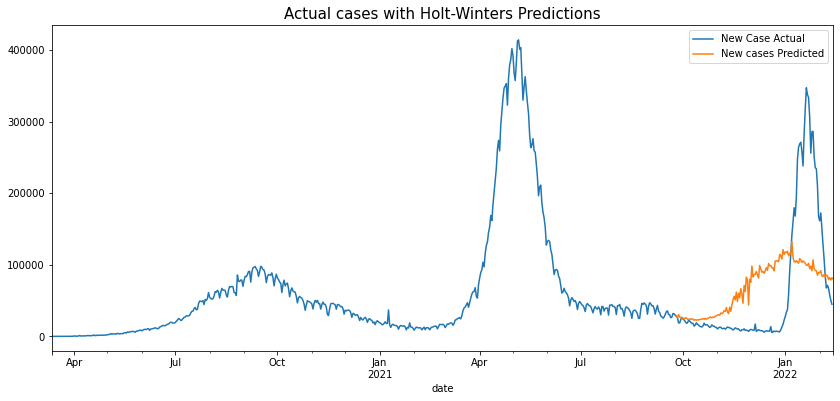

In [78]:
ind['new_cases'].plot(figsize=(14, 6), label = 'New Case Actual')
np.exp(holts_predict).plot(label = 'New cases Predicted')
plt.legend()
plt.title('Actual cases with Holt-Winters Predictions', fontsize = 15)
plt.show()

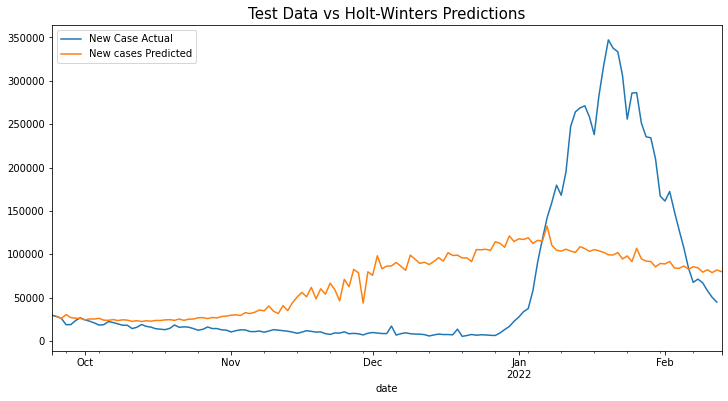

In [79]:
test_df['new_cases'].plot(label = 'New Case Actual')
np.exp(holts_predict).plot(label = 'New cases Predicted')
plt.legend()
plt.title('Test Data vs Holt-Winters Predictions', fontsize = 15)
plt.show()

In [80]:
mean_squared_error(test_df['new_cases'], np.exp(holts_predict), squared=False)

83999.66588116159

In [81]:
mean_absolute_percentage_error(test_df['new_cases'], np.exp(holts_predict))

3.607798890807207

- Compared to the previous models, Holt-Winters model managed to capture the third wave, albeit with high RMSE value.

##### Training on full data

In [82]:
holts_full = ExponentialSmoothing(ind['log_trans'],
                                   trend = 'add', 
                                   seasonal = 'add', 
                                   seasonal_periods = 121).fit()

In [101]:
aic_scores['Holt-Winters'] = holts_full.aic

In [83]:
holts_full_predict = holts_full.forecast(28)
np.exp(holts_full_predict)

2022-02-13    40219.449078
2022-02-14    36288.981907
2022-02-15    32190.804505
2022-02-16    29299.324928
2022-02-17    27101.128614
2022-02-18    24780.173039
2022-02-19    22616.132847
2022-02-20    19468.894276
2022-02-21    18143.406794
2022-02-22    16038.661671
2022-02-23    14616.823047
2022-02-24    13411.879120
2022-02-25    12075.924301
2022-02-26    10988.270757
2022-02-27     9723.981581
2022-02-28     8974.302718
2022-03-01     8119.590406
2022-03-02     7251.888891
2022-03-03     6755.191320
2022-03-04     6054.735641
2022-03-05     5902.856803
2022-03-06     5021.304638
2022-03-07     4668.771595
2022-03-08     4553.301942
2022-03-09     3917.508807
2022-03-10     4070.810514
2022-03-11     3267.474879
2022-03-12     2737.822029
Freq: D, dtype: float64

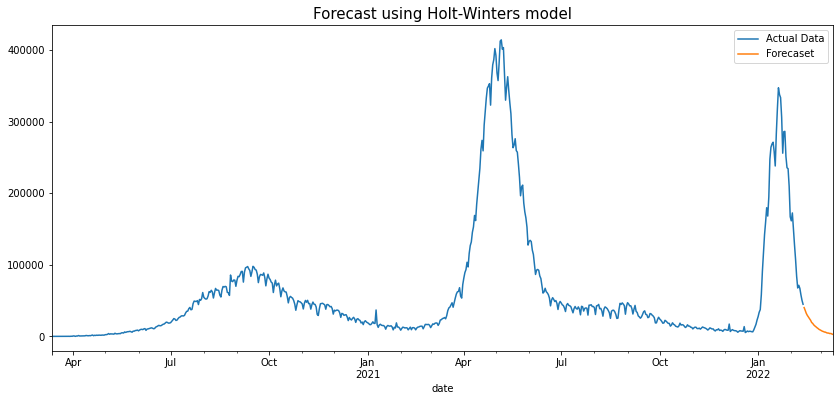

In [84]:
ind['new_cases'].plot(figsize=(14, 6), label = 'Actual Data')
np.exp(holts_full_predict).plot(label = 'Forecaset')
plt.title('Forecast using Holt-Winters model', fontsize=15)
plt.legend()
plt.show()

- After training on full data, the model gave relatively good predictions. To validate this, we have collected latest data after the beginning of this work.

##### Validating on Latest Data

In [85]:
india_latest = pd.read_csv('/content/drive/MyDrive/Project/Data/india_latest11.csv')
india_latest

,date,new_cases
0,13-02-2022,34113
1,14-02-2022,27409
2,15-02-2022,30615
3,16-02-2022,30757
4,17-02-2022,25920
5,18-02-2022,22270
6,19-02-2022,19968
7,20-02-2022,16051
8,21-02-2022,13405
9,22-02-2022,15102


In [86]:
india_latest.set_index(holts_full_predict.index, inplace = True)
india_latest.drop('date', axis = 1, inplace = True)
india_latest

,new_cases
2022-02-13,34113
2022-02-14,27409
2022-02-15,30615
2022-02-16,30757
2022-02-17,25920
2022-02-18,22270
2022-02-19,19968
2022-02-20,16051
2022-02-21,13405
2022-02-22,15102


In [87]:
india_latest.index

DatetimeIndex(['2022-02-13', '2022-02-14', '2022-02-15', '2022-02-16',
               '2022-02-17', '2022-02-18', '2022-02-19', '2022-02-20',
               '2022-02-21', '2022-02-22', '2022-02-23', '2022-02-24',
               '2022-02-25', '2022-02-26', '2022-02-27', '2022-02-28',
               '2022-03-01', '2022-03-02', '2022-03-03', '2022-03-04',
               '2022-03-05', '2022-03-06', '2022-03-07', '2022-03-08',
               '2022-03-09', '2022-03-10', '2022-03-11', '2022-03-12'],
              dtype='datetime64[ns]', freq='D')

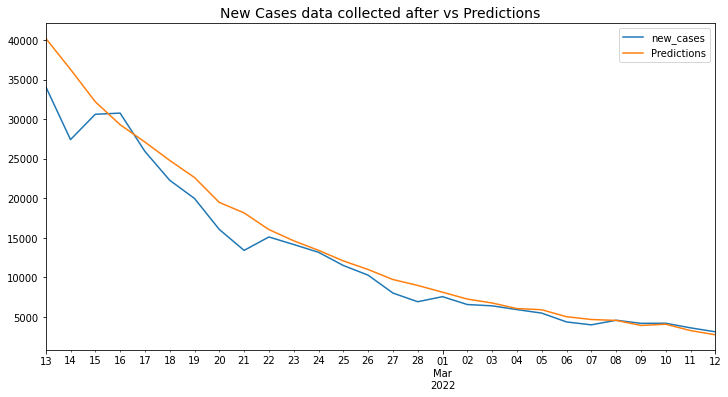

In [88]:
india_latest.plot(label = 'New Cases')
np.exp(holts_full_predict).plot(label = 'Predictions')
plt.title('New Cases data collected after vs Predictions', fontsize=14)
plt.legend()
plt.show()

In [89]:
print(f'\nThe RMSE values is: {round(mean_squared_error(india_latest, np.exp(holts_full_predict), squared = False), 2)}')
print(f'\nThe mean of newly collected series is: {round(india_latest.mean(), 2)}')


The RMSE values is: 2543.42

The mean of newly collected series is: new_cases    12841.79
dtype: float64


- Plotting the predictions and new data, we see the model has captured the downward trend more or less acurately.
- The real life data however possess high variations which was not captured.
- Because of this, we get a RMSE value of 2543.42 for a series having mean 12841.79, which though not highly accurate, given the erratic nature of the data is not a bad prediction.

#### AIC Scores Comparison

In [102]:
print(aic_scores)

{'ARIMA': -38.8966298576656, 'SARIMA': -169.9553203668744, 'Holt-Winters': -1915.6561619035579}


The Akaike Information Criterion (AIC) lets you test how well your model fits the data set without over-fitting it.The AIC score rewards models that achieve a high goodness-of-fit score and penalizes them if they become overly complex.By itself, the AIC score is not of much use unless it is compared with the AIC score of a competing model.

The model with the lower AIC score is expected to strike a superior balance between its ability to fit the data set and its ability to avoid over-fitting the data set.

As expected Holt-Winters has the lowest AIC score of all the models and the low negative value indicates less loss of information overall. 

##### Predicting The next 4 month values

In [90]:
holts_future = holts_full.forecast(121)

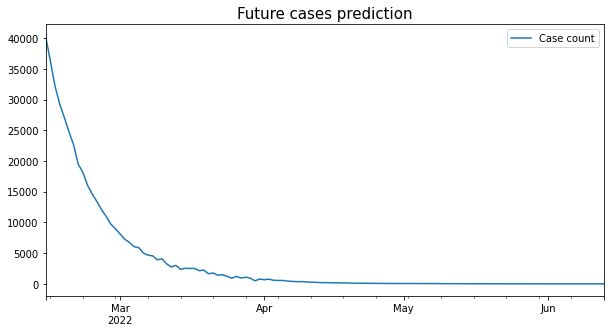

In [91]:
np.exp(holts_future).plot(figsize=(10, 5), label = 'Case count')
plt.title('Future cases prediction', fontsize = 15)
plt.legend()
plt.show()

- Forecasting four months into the future, we see no evidence of a fourth wave in that period. 
> This however doesn't mean a fourth wave is unlikely. We simply lack the means to take into account external factors, vaccination drives and newer Covid strains. Hence new situations could bring about new waves. So it is advisable to maintain safety protocols.

######################################